In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# load args
DUMP_PATH = "dump/Kolmogorov6_ppo_cgs1_fgs16/"

with open(DUMP_PATH+'config_20240810-020145.pkl', 'rb') as f:
    args = pickle.load(f)

In [ ]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:30]
val_seeds = seeds[30:]
#test_seeds = np.array([69, 33, 420])

train_env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)
test_env = KolmogorovEnvironment7(seeds=val_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)

In [ ]:
actor = MyFCNNActorProb(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb(in_channels=2, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=args.deterministic_eval,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [ ]:
#######################################################################################################
####### Collectors ####################################################################################
#######################################################################################################
#train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, len(train_env)))
train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, 1))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#######################################################################################################
####### Trainer #######################################################################################
#######################################################################################################
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=2,
    step_per_epoch=args.step_per_epoch,
    repeat_per_collect=args.repeat_per_collect,
    episode_per_test=args.episode_per_test,
    batch_size=args.batch_size,
    step_per_collect=args.step_per_collect,
    #episode_per_collect=args.episode_per_collect,
    show_progress=True,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
)

In [ ]:
trainer.run()

# iterate through all seeds and print intial voriticity in a grid

In [ ]:
vorts = np.zeros((seeds.shape[0], 128,128))
for i in range(seeds.shape[0]):
    env = KolmogorovEnvironment6(seeds=np.array([seeds[i]]))
    vorts[i,...] = env.get_vorticity()
    env.close()


In [ ]:
# plot vorticity images at times t1 to t5 for all resolutions
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.8)
fig, axs = plt.subplots(4, 8, figsize=(8,4), dpi=300)
# add tight layout
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(8):
    for j in range(4):     
        axs[j, i].imshow(vorts[4*i+j], vmin=-12, vmax=12, cmap=sn.cm.icefire)
        #axs[j, i].axis('off')
        # disable ticks 
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].text(0.04, 0.04, f"{seeds[4*i+j]}", ha='left', va='bottom', fontsize=6, color='black', bbox=bbox_props, transform=axs[j,i].transAxes)
plt.show()

# plot energy spectrum over the coarse of a simulation between fgs and cgs

In [ ]:
env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=1536-1, step_factor=1)

In [ ]:
import time
#time one klmgrv5 episode
start_time = time.time()
reward = 0
discounted_reward = 0
gamma = 0.99
step = 0
act = np.ones(env.action_space.shape)
#act[32:96, 32:96] = 0.92
obs ,inf = env.reset()
rew = 0
episode_is_over = False
while not episode_is_over:
    if step%500==0:
        print(step, rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        E1, E2 = env.get_spectra()
        plt.style.use('ggplot')
        plt.figure(figsize=(8, 5), dpi=100)
        plt.loglog(E1, label='cgs')
        plt.loglog(E2, linestyle='dashed', label='fgs')
        plt.ylabel(r'Energy spectrum $E(k)$')
        plt.xlabel(r'wavenumber $k$')
        plt.legend()
        plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    discounted_reward += rew * gamma**step 
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True



print(f"#steps = {step}, Total Reward = {reward}, Total discounted Reward = {discounted_reward}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# load and look at trained policz

In [3]:
# load args
DUMP_PATH = "dump/Kolmogorov8_ppo_cgs1_fgs16/"
#ID = "20240813-170058"
ID = "20240814-173551"

with open(DUMP_PATH+'config_'+ID+'.pkl', 'rb') as f:
    args = pickle.load(f)

In [4]:
 #######################################################################################################
####### environments ##################################################################################
#######################################################################################################
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
              99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
              160, 313, 21, 252, 235, 344, 42])
assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:29]
val_seeds = seeds[29:]
#test_seeds = np.array([69, 33, 420])

train_env = KolmogorovEnvironment8(seeds=train_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)
test_env = KolmogorovEnvironment8(seeds=val_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0
m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


In [11]:
#######################################################################################################
####### Policy ########################################################################################
#######################################################################################################
actor = MyFCNNActorProb(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb(in_channels=2, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=False,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    vf_coef = args.vf_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [12]:
#load trained bolicy
policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))

<All keys matched successfully>

In [17]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
act_means = []
act_maxs = []
act_mins = []
act_stds = []
std_means = []
episode_is_over = False
act = np.ones(train_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    act_means.append(act.reshape(128,128).mean())
    act_mins.append(act.reshape(128,128).min())
    act_maxs.append(act.reshape(128,128).max())
    act_stds.append(act.reshape(128,128).std())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    reward += rew
    step += 1
    if step%200==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        test_env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

terminated
#steps = 178, Total Reward = 177.98567714472654


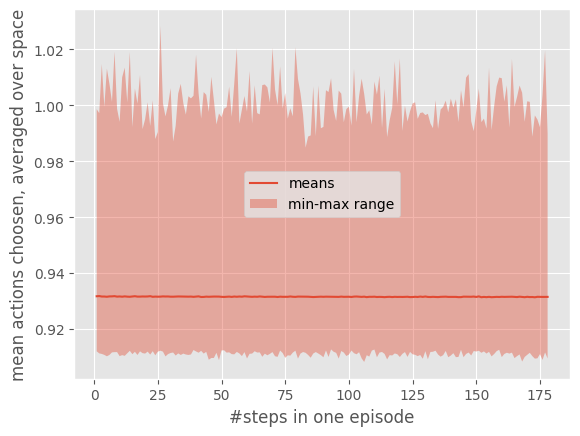

In [18]:
act_means = np.array(act_means)
act_maxs =np.array( act_maxs)
act_mins =np.array( act_mins)
act_stds =np.array( act_stds)
std_means = np.array(std_means)

#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.fill_between(t, act_mins, act_maxs, alpha=0.4, label="min-max range")
#plt.fill_between(t, act_means-act_stds, act_means+act_stds, alpha=0.4, label="min-max range")
#plt.plot(t, act_mins, label="mins")
#plt.plot(t, act_maxs, label="maxs")
#plt.ylim([0.9,1.1])
plt.legend()
plt.xlabel("#steps in one episode")
plt.ylabel("mean actions choosen, averaged over space")
plt.show()

In [15]:
obs, inf = test_env.reset()
mean, std = policy(Batch(obs=np.array([obs]), info={})).logits.detach().cpu().numpy()
acts_taken = policy(Batch(obs=np.array([obs]), info={})).act.detach().cpu().numpy().reshape(128,128)
mean, std = mean.reshape(128,128), std.reshape(128,128)
v = test_env.get_vorticity()

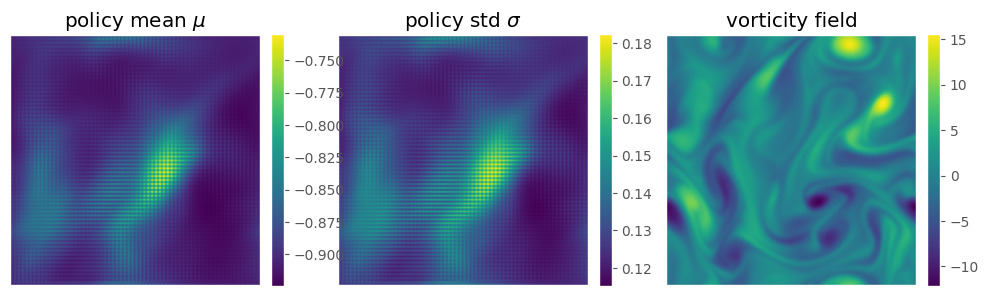

In [16]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', origin='lower')
im2 = axs[1].imshow(std, cmap='viridis', aspect='equal', origin='lower')
im3 = axs[2].imshow(v, cmap='viridis', aspect='equal', origin='lower')

axs[0].set_title(r"policy mean $\mu$")
axs[1].set_title(r"policy std $\sigma$")
#axs[2].set_title(r"sampled actions $a \sim \mathcal{N}(\mu, \sigma)$")
axs[2].set_title(r"vorticity field")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xticks([])


cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
plt.show()

In [19]:
# load training stats
with open(DUMP_PATH+'training_stats_'+ID+'.pkl', 'rb') as f:
    stats = pickle.load(f)

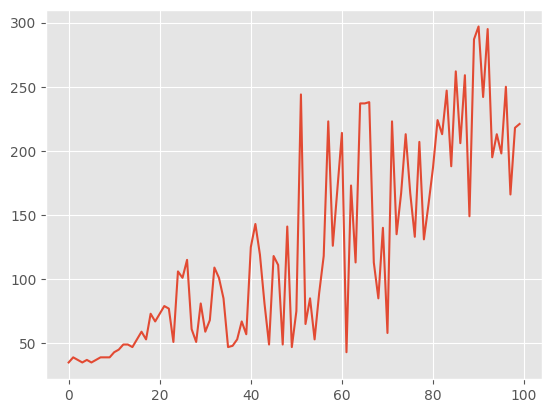

In [29]:
plt.plot(stats["rew"])
#stats[0]

In [18]:
#env.close()
train_env.close()
test_env.close()
#trainer.reset()

: 